# MODEL

We will use the TensorFlow Object Detection API <br>
https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/ <br>

Once the API is installed we can import libraries and load some useful settings

In [1]:
import os
import time
import pandas as pd
import numpy as np
import pathlib
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# Enable GPU dynamic memory allocation
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

C:\Users\Mario\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Mario\anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\Mario\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Now we extract all the filenames

In [2]:
path = 'cars/imgs/'
f = []
for (dirpath, dirnames, filenames) in os.walk(path):
    f.extend(filenames)
    break
IMAGE_PATHS = [path + name for name in f]

The next step is to download and extract the model <br>
We can choose among the followings models: <br>
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md

In [3]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200713'
MODEL_NAME = 'centernet_hg104_512x512_coco17_tpu-8'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)
#http://download.tensorflow.org/models/object_detection/tf2/20200713/centernet_hg104_512x512_coco17_tpu-8.tar.gz

Extracting labels file and category indexes needed for classification

In [4]:
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

Once the model is downloaded we can load it into our environment and instantiate a detector

In [5]:
#TAKE APPROX 3 min, couldn't find a way to suppress these warnings so just close output cell in Jupyter Notebook
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

#### Everything is ready, we can now run the detector, this cell does the following for every image in our dataset:
<br>`
• Load image into a numpy array then prepare it for the detector
• Run the detector over the image
• Convert the detection to a dict and then keep just the 'cars' detection in a DataFrame
• If we have at least a car detected we plot the image with the relative detection and save the results
`

Processing 200  images...
1 

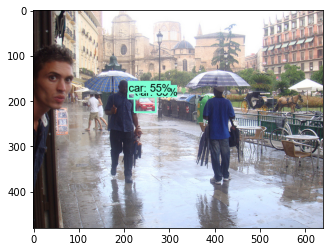

2 

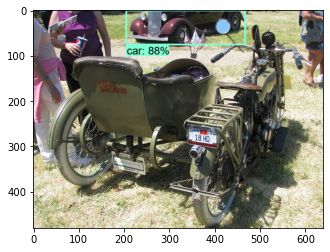

3 

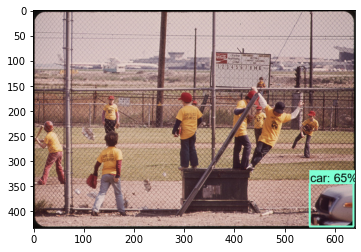

4 

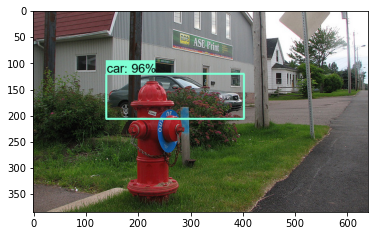

5 

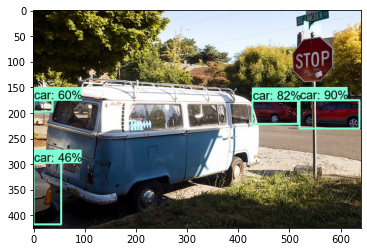

6 

KeyboardInterrupt: 

In [27]:
%%time
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    return np.array(Image.open(path))


finalDF = pd.DataFrame()

count = 0
print('Processing',len(IMAGE_PATHS),' images...')

for image_path in IMAGE_PATHS:
    count += 1
    print(count,end=' ')
    if(count % 25 == 0):
        print('')
    #Load image into a numpy array then prepare it for the detector
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]
    
    #Run the detector over the image
    detections = detect_fn(input_tensor)
    # Convert the detection to a dict
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    #keep just the 'cars' detection in a DataFrame
    #we keep also the confidence score, the file name and the image dimension, we will need them later to perform some bounding box transformation
    det = pd.DataFrame.from_dict({'class' : detections['detection_classes'], 'boxes' : list(detections['detection_boxes']), 'score' : detections['detection_scores']
                       , 'file_name': image_path, 'image_H' : image_np.shape[0], 'image_W' : image_np.shape[1]  })
    det = det[det['class'] == 3]
    
    #If we have at least a car detected we plot the image with the relative detection
    image_np_with_detections = image_np.copy()
    if len(det) > 1:
        viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              np.array(det['boxes']),
              np.array(det['class']),
              np.array(det['score']),
              category_index,
              use_normalized_coordinates=True,
              max_boxes_to_draw=30,
              min_score_thresh=.4,
              agnostic_mode=False)

        plt.figure()
        plt.imshow(image_np_with_detections)
        plt.show()
        
        #and finally we save the results
        finalDF = pd.concat((finalDF,det))
    else: continue

In [ ]:
finalDF.file_name = finalDF.file_name.apply(lambda x: x.split('/')[2])
finalDF.head()

# EVALUATION

Once we obtained our prediction we will evaluate the results of the model <br>
To do so we extract the bounding boxes of the cars inside the JSON file <br>
as stated in the COCO documentation these Bounding Boxes are in the format: <br>
`"bbox": [xmin,ymin,width,height],`

In [ ]:
%%time
json=pd.read_json (r'cars\\annotations_sample.json')

area = []
file_name = []
bbox = []

for annotation in json['annotations']:
    if annotation['category_id'] == 3 and annotation['iscrowd'] == 0:
        area.append(annotation['area'])
        file_name.append(annotation['file_name'])
        bbox.append(annotation['bbox'])


dataInfo = pd.DataFrame({'area':area, 'file_name':file_name, 'bbox':bbox})
del json, area, file_name, bbox
dataInfo.head()

To calculate some accuracy metric we need to define a way to know <br>
when to consider two bounding boxes as a match or not, to do so <br>
we will use a common 'accuracy' metric for bounding boxes defined <br>
as the ratio of the intersection area between the two rectangles and the <br>
union area, this value is in the range [0,1]

In [ ]:
# Inter Over Union starting from COCO 'xmin ymin xmax ymax' format
def bb_intersection_over_union(boxA, boxB):
    #calculate intersection width and heigth
    dx = min(boxA[0] + boxA[2], boxB[0] + boxB[2]) - max(boxA[0], boxB[0])
    dy = min(boxA[1] + boxA[3], boxB[1] + boxB[3]) - max(boxA[1], boxB[1])
    if (dx>=0) and (dy>=0):
        area_Inter = dx*dy
        area_A = boxA[2] * boxA[3]
        area_B = boxB[2] * boxB[3]
        area_Union= area_A + area_B - area_Inter
        return area_Inter / area_Union
    else: return(0)

### Extract COCO format Bounding Boxes from TensorFlow Format

Before checking for matches between our prediction and the test data <br>
we need to transform the Bounding Box representation of Tensorflow <br>
to match the COCO Format previously described

In [ ]:
#transform TensorFlow's normalized [ymin,xmin,ymax,xman] representation to COCO's absolute [xmin,ymin,xmax,ymax] format
def TensorBoxToCocoFormat(x):
    bbox = x['boxes']
    H = x['image_H']
    W = x['image_W']
    rect = list((bbox[1] * W, bbox[0] * H, bbox[3] * W - bbox[1] * W, bbox[2] * H - bbox[0] * H))
    return( [np.around(a,2) for a in rect] )

finalDF['COCO'] = finalDF.apply(lambda x: TensorBoxToCocoFormat(x), axis = 1)
finalDF.head()

Now we define a function to calculate the match between the prediction and the annotations <br>
The matching algorithm follow this pseudo-code: 
<br>
`
• Sort the prediction by confidence
• For each prediction look up the true bounding boxes in the image
• For each bounding box if is not already matched then we run Intersection over Union measure, 
  if IoU is grater then 0.5 we have a match
• When we find a match we flag that ground truth record as already matched and we consider that prediction
  as a correct one
`

In [ ]:
def matchBBox(x):
    #Get all boxes of same pic
    picBoxes = truth[truth['file_name'] == x['file_name']]
    for index, row in picBoxes.iterrows():
        # IF BBOX IS NOT ALREADY MATCHED
        if(row['matched'] == False):
            # CHECK MATCH
            IoU = bb_intersection_over_union(row['bbox'], x['COCO'])
            if(IoU > 0.5):# IF MATCH:  #FLAG BBOX AS MATCHED AND RETURN 1
                truth.at[index,'matched'] = True
                return(1)
        else:  continue
    return(0)

Finally we can run the matching process, these are the steps: 

In [ ]:
#Appending flag column
truth = dataInfo.copy()
truth['matched'] = np.zeros(len(dataInfo),dtype=np.bool)

#sorting and running matching
finalDF = finalDF.sort_values(by='score',ascending=False)
finalDF['matched'] = finalDF.apply(lambda x: matchBBox(x), axis = 1)
finalDF.head()

We now obtained an array of 1 and 0, 1 for the prediction who found a match, 0 otherwise, to extract <br>
a quality measure we can now use the Average Precision, which is a more suitable metric for this kind of problem. <br>
Average Precision use the confidence score to obtain a better insight of the model performance: <br>
in case of a non-matching prediction, the result will be weighted with respect to the confidence score so that <br>
a bad prediction with high confidence will be considered worse than a bad prediction with low confidence.

For more info: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html

### AVERAGE PRECISION

In [ ]:
from sklearn.metrics import average_precision_score as AP

np.around(AP(finalDF['matched'], finalDF['score']),2)

In the following table, we can see the Average Precision score, <br> 
the model Size and the time for the predictions of different models

|                   Model   Name           	|  AP  	| Model Size(MB) 	| Time for Preds(s) (Nvidia GTX 970) 	|
|:----------------------------------------:	|:----:	|:--------------:	|:----------------------------------:	|
| SSD MobileNet v2 320x320                 	| 0,61 	|       40       	|                 24                 	|
| Faster R-CNN ResNet50 V1 640x640         	| 0,76 	|       233      	|                 66                 	|
| Faster R-CNN ResNet101 V1 1024x1024      	| 0,82 	|       337      	|                 67                 	|
| EfficientDet D4 1024x1024                	| 0,85 	|       151      	|                 240                	|
| EfficientDet D7 1536x1536                	| 0,91 	|       376      	|                 550                	|
| SSD ResNet152 V1 FPN 1024x1024          	| 0,86 	|       480      	|                 174                	|
| ⭐CenterNet HourGlass104 512x512⭐     	| 0,94 	|      1320      	|                 87                 	|
| CenterNet HourGlass104 1024x1024         	| 0,89 	|      1320      	|                 166                	|

The chosen model is `the CenterNet HourGlass104 512x512`. <br>

To confirm the result of AP we can calculate the mean confidence score when we either found a match or not.

In [ ]:
np.around(finalDF.groupby(finalDF['matched']).score.mean(),2)

As we can see from this result we discover that when the model outputs a bounding box <br>
that is not considered as a match from our matching algorithm. the mean confidence is really low

In [ ]:
finalDF['matched'].value_counts()

We also see that our model outputs a lot of unmatched bounding boxes <br>
but we know that the majority of these wrong predictions have a low confidence score <br>
so we can conclude that a good way to eliminate the majority of wrongs prediction <br>
but also keep the good one would be to consider only the predictions over a given threshold.

In [ ]:
import seaborn as sns
sns.displot(data=finalDF, x='score', hue='matched', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.6)

In this graph, we can see the confidence score distribution for matched and not matched predictions <br>
a value around 0.4 seems to be the best tradeoff to discard low confidence prediction<br>
while trying to keep good ones, given this informations we will use this value as a threshold<br>
to know which predictions we want to keep for a general-purpose car recognition model.<br>
Depending on the costs of our prediction we can consider changing this value in the range [0.2; 0.6]<br>

To conclude our work we convert the bounding box to the desired format, we filter out<br>
low confidence prediction and we export the final .csv file

To conclude our work we convert the bounding box to the desired format, we filter out <br>
low confidence prediction and we export the final .csv file

In [ ]:
#Function to convert the TensorFlow Bounding Boxes to the desired format (Cx,Cy,H,W)
def convertBox(x):
    ymin = x['boxes'][0]
    xmin = x['boxes'][1]
    ymax = x['boxes'][2]
    xmax = x['boxes'][3]
    
    Cx = ((xmin + xmax) / 2 ) * x['image_W']
    Cy = ((ymin + ymax) / 2 ) * x['image_H']
    H  = (ymax - ymin) * x['image_H']
    W  = (xmax - xmin) * x['image_W']
    
    return( list( map( int, (Cx,Cy,H,W) ) ) ) 

finalDF['CenteredBBox'] = finalDF.apply(lambda x: convertBox(x), axis=1)

In [ ]:
output = finalDF[finalDF['score'] > 0.4 ] [['file_name','CenteredBBox']]
output.to_csv('output.csv',header=False, index=False)
output